<a href="https://colab.research.google.com/github/atikuzzamankhu/MobileSAM-Medical-Imaging/blob/main/MobileSAM_Medical_Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usecase of SAM for Medical Imaging

The Medical SAM (Segment Anything Model) repository is a fork of the original SAM repository with modifications to support object segmentation in medical imaging using DICOM files. The SAM model is a state-of-the-art object segmentation model that predicts object masks given prompts that indicate the desired object. This implementation uses SAM to efficiently produce high-quality masks from prompts for medical imaging tasks using DICOM files. It allows the user to provide box prompt via the SamPredictor class to predict masks for a given medical DICOM file.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [2]:
import sys

In [3]:
if 'google.colab' in sys.modules:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture2.jpg
    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-8jjqghe4
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-8jjqghe4
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 01ea8d0f5590082f0c1ceb0a3e2272593f20154b
  Preparing metadata (setup.py) ... done
  Created wheel for mobile-sam: filename=mobile_sam-1.0-py3-none-any.whl size=42433 sha256=131342338437fdc30ef04b3f462bb4057b54b318f55608594c850ee83c696ebe
  Stored in directory: /tmp/pip-ephem-wheel-cache-w4y_l4vv/wheels/43/b1/9d/1c1b33c31d4c54f0a502f9c48b655f87213ab01e55d09cf4ef
Successfully built mobile-sam
--2023-07-04 03:12:47--  https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.

## Clone the Repo
The code for the SAM setup can be cloned directly from my repo [here](https://github.com/amine0110/SAM-Medical-Imaging).

In [4]:
!git clone https://github.com/amine0110/SAM-Medical-Imaging

Cloning into 'SAM-Medical-Imaging'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 50 (delta 13), reused 34 (delta 5), pack-reused 0
Unpacking objects: 100% (50/50), 1.01 MiB | 7.00 MiB/s, done.


In [6]:
!pip install pydicom
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
import pydicom
from google.colab.patches import cv2_imshow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.2 MB/s eta 0:00:00


In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 200/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

### Import a classic image

In [8]:
image = cv2.imread('SAM-Medical-Imaging/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Import a medical imaging image (dcm image)

In [9]:
def prepare_dicoms(dcm_file, show=False):
    dicom_file_data = pydicom.dcmread(dcm_file).pixel_array

    HOUNSFIELD_MAX = np.max(dicom_file_data)
    HOUNSFIELD_MIN = np.min(dicom_file_data)

    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

    dicom_file_data[dicom_file_data < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    dicom_file_data[dicom_file_data > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    normalized_image = (dicom_file_data - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE
    uint8_image = np.uint8(normalized_image*255)

    opencv_image = cv2.cvtColor(uint8_image, cv2.COLOR_GRAY2BGR)

    if show:
        cv2_imshow(opencv_image)

    return opencv_image

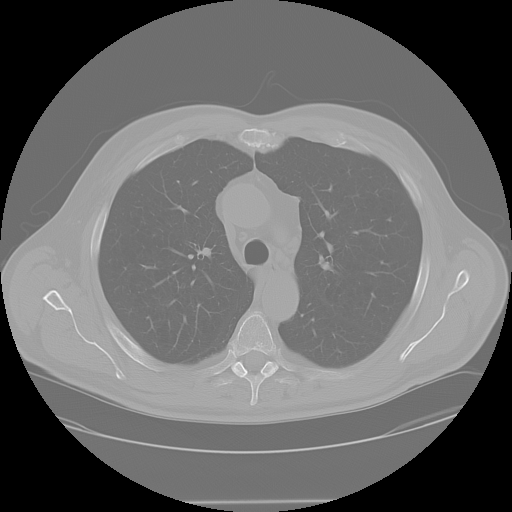

In [10]:
img = prepare_dicoms('SAM-Medical-Imaging/images/slice.dcm', show=True)

In [11]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00


In [12]:
import sys
sys.path.append("..")
from mobile_sam import sam_model_registry, SamPredictor

sam_checkpoint = "mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

predictor = SamPredictor(sam)

In [13]:
predictor.set_image(img)

In [14]:
input_box = np.array([100, 100, 400, 400])

In [15]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

### Show Image + Output Mask + Bounding Box

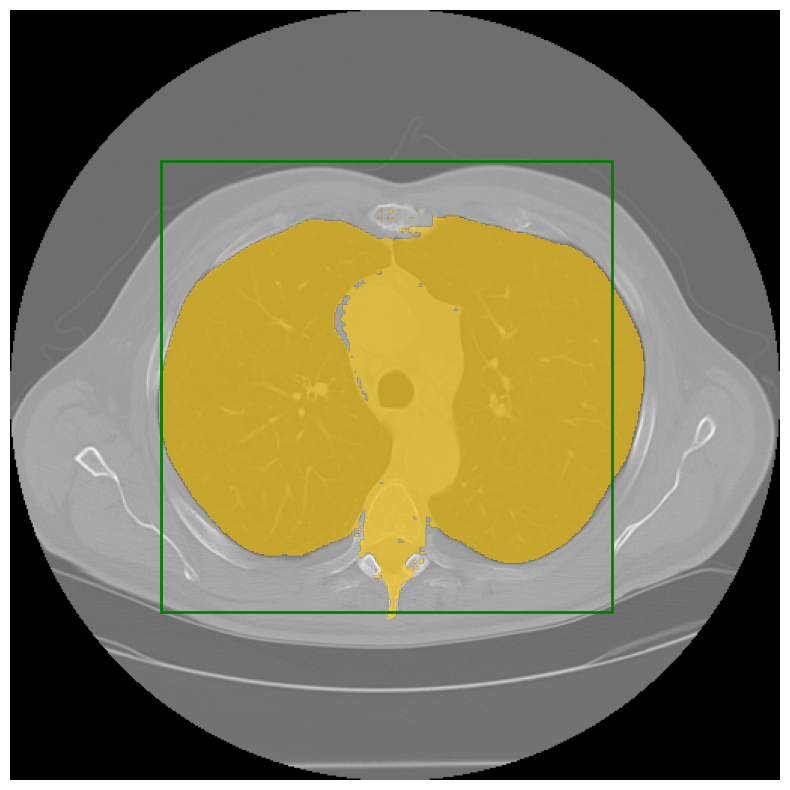

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()